# Scikit-Learn Sentiment Bot

This is a binary text classification problem, that is sentiment is either negative or positive.

In this tutorial, we will create a sentiment model by

1.  Create a featurizer to extract important features from a movie review database.
2.  Classify the text features with a linear classifier along with performing a grid search to tune the hyperparameters.

The author of the code to create this model was written by Olivier Grisel <olivier.grisel@ensta.org> under the Simplified BSD license.

In this tutorial you will

1.  [Train the model](#train)

2.  [Explore the scikit-learn connector](#explore)

3.  [Explore the sentiment bot code](#bot)



In [1]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# For when background is dark:
sns.set(rc={'text.color': 'white', 'axes.labelcolor': 'white'})

<a id='train'></a>
# Train the model
Navigate to `tutorials/sentiment/` on the command line to begin working with the files.


## Get the data
Go into the `movie_reviews` folder and run the `fetch_data.py` command as follows.

In [2]:
! cd movie_reviews; python fetch_data.py

In [3]:
! ls movie_reviews/txt_sentoken

neg pos


Load the negative and positive movie review files.

In [4]:
# the training data folder must be passed as first argument
movie_reviews_data_folder = 'movie_reviews/txt_sentoken'
# load_files loads text files where the subfolders are the labels
dataset = load_files(movie_reviews_data_folder, shuffle=False)
print("n_samples: %d" % len(dataset.data))

n_samples: 2000


In [5]:
dataset.target_names

['neg', 'pos']

Split the dataset in training and test set.

In [6]:
docs_train, docs_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.25, random_state=42)

## Extract text features and train model

![https://imgs.xkcd.com/comics/malamanteau.png](https://imgs.xkcd.com/comics/malamanteau.png)

We will use `sklearn`'s `CountVectorizer` to extract features from the text documents as n-gram tokens.  This creates a matrix across all documents, recording counts for the tokens.

What is an n-gram?  Take a look at the formation of unigrams, bigrams and trigrams below.

![n-gram](https://www.simplicity.be/articles/throwing-dices-recognizing-west-flemish-and-other-languages/img/ngrams.jpg)


We also will use term frequency inverse document frequency (TFIDF), in the form of `TfidfTransformer`, on the n-gram tokens to make very common words contribute less information and boost the significance of less common words.

We're also going to see **Piplelines.**  A pipeline is used in `sklearn` to link steps together to automate the training process, testing process etc. and also make hyperparameter tuning across a set of steps easier in combination with a grid search.

So, we'll build a featurizer / classifier pipeline that filters out tokens that are too rare or too frequent (using TFIDF and applying a linear classifier).

We'll use a linear support vector machine (SVM) classifier, which is widely regarded as one of the best text classification algorithms (although it’s a bit slow to train).

If you're wondering what an SVM classifier is, think of it this way:  there are two hyperplanes that can form a gap that separates two classes of data points.  That gap or margin is then called the _maximum margin_ and has a certain width (shown here in 2D space).  Certain data points (which can be N-dimensional vectors) that lie on the one of the two hyperplanes are called _support vectors_.  The plane that is half-way between these two marginal hyperplanes is called the _maximum-margin hyperplane_.



![SVM wikipedia](http://www.saedsayad.com/images/SVM_2.png)

The following just initializes the Pipeline - we haven't trained anything yet.

In [7]:
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
])

Build a grid search to find out whether unigrams or bigrams are more useful.

Fit the pipeline on the training set using grid search for the parameters.  Grid search is how we do our hyperparameter tuning.

In [8]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__C': (10, 100, 1000),
}

# The multiprocessing module is used as the backend of joblib.Parallel 
# when n_jobs != 1
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__C': (10, 100, 1000), 'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Check the score and parameters that landed us the best classifier.

In [9]:
print('Score: ', grid_search.best_score_)                              

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))

Score:  0.839333333333
clf__C: 10
tfidf__use_idf: True
vect__ngram_range: (1, 1)


Predict the outcome on the testing set and store it in a variable named y_predicted.

In [10]:
y_predicted = grid_search.predict(docs_test)

Print the classification report.

In [11]:
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

             precision    recall  f1-score   support

        neg       0.83      0.81      0.82       257
        pos       0.81      0.82      0.81       243

avg / total       0.82      0.82      0.82       500



Print and plot the confusion matrix.

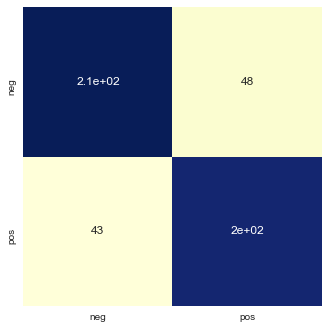

In [12]:
cm = metrics.confusion_matrix(y_test, y_predicted)
df = pd.DataFrame(cm)
df.columns = ['neg', 'pos']
df.index = ['neg', 'pos']
cm_heatmap = sns.heatmap(df, 
            square=True, 
            annot=True, 
            cbar=False, 
            cmap="YlGnBu", 
            xticklabels=True,
            yticklabels=True)


# if you don't have seaborn just comment out the sns line and uncomment:
# print(cm)

Persist our model by saving.

In [13]:
joblib.dump(grid_search, 'sentiment.pkl')

['sentiment.pkl']

<a id='explore'></a>
# Explore the `scikit-learn` connector

Test the model with the scikit-learn connector (sklearn_connector module)

### Get the model from Azure

Download the sentiment classifier by clicking [https://odsc2017.blob.core.windows.net/models/sentiment.pkl](https://odsc2017.blob.core.windows.net/models/sentiment.pkl)

### Use `pybotframework`'s scikit-learn connector

In [14]:
from pybotframework.sklearn_connector import SklearnConnector

In [15]:
target_names = ['neg', 'pos'] # order does matter
sklearn_lang_conn = SklearnConnector(model_file='sentiment.pkl',
                                     target_names=target_names)

### Test the connector

In [16]:
sklearn_lang_conn.respond("I really liked it.")

'pos'

In [17]:
sklearn_lang_conn.respond("I thought it was hilarious.")

'pos'

In [18]:
sklearn_lang_conn.respond("I thought it could have used better music.")

'neg'

In [19]:
sklearn_lang_conn.respond("The singing was atrocious.")

'neg'

This is what the bot will use to understand the sentiment of what you write.

<a id='bot'></a>

# Sentiment Bot Example
Now we will go over the Lang Bot code at `examples/lang_bot` to see how this bot is made.


# Exercises

1.  Download [this](https://odsc2017.blob.core.windows.net/models/text_clf.zip) language model.  Instatiate a connector with this model file and the following class labels from the 20 newsgroups dataset, then test the connector.
Labels:
```
'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
```
3.  See if you can use the RegexConnector from the first tutorial, add this connector to your bot and then chain them together when you instantiate your BotFramework object.
```
   BotFramework(connectors=[regex_conn, sklearn_conn], ...)
```
2.  Update the classifier to a RandomForestClassifier and tune on the n_estimators with grid search.
3.  Find a more complex, larger corpus and extract features to train a new model (such as [this](http://ai.stanford.edu/~amaas/data/sentiment/) Stanford one).
